### Load Packages:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
import csv
import math
import os
import sys
from sklearn.preprocessing import scale

%matplotlib inline

## Load data:

In [21]:
def load_data(file_name):
    """
    This function load the data into the data structures that we need.
    """
    X = np.loadtxt(file_name, dtype='float', delimiter=',', usecols=np.arange(3,13))
    X1 = scale(X, axis=1)
    X = np.hstack((np.ones((X.shape[0],1)), X1))

    cl = np.loadtxt(file_name, dtype='str', delimiter=',', usecols=[1])
    # Set Malignant to be 1 and Benign to be 0
    y = (cl == 'M').astype(float)

    train_set_x = X.T
    train_set_y = y.reshape(y.shape[0],1).T

    test_set_x = train_set_x
    test_set_y = train_set_y
    
    return (train_set_x, train_set_y, test_set_x, test_set_y)

file_name = '../../../data/wdbc.csv'
train_set_x, train_set_y, _,_ = load_data(file_name)
print(train_set_x.shape)


(11, 569)


In [3]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """

    ### START CODE HERE ### (≈ 1 line of code)
    s = 1. / (1. + np.exp(-z))
    ### END CODE HERE ###
    
    return s

In [4]:
def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
    
    ### START CODE HERE ### (≈ 1 line of code)
    w = np.zeros((dim,1))
    b = 0.0
    ### END CODE HERE ###

    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

In [5]:
def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    
    Tips:
    - Write your code step by step for the propagation. np.log(), np.dot()
    """
    
    m = X.shape[1]
    
    # FORWARD PROPAGATION (FROM X TO COST)
    ### START CODE HERE ### (≈ 2 lines of code)
    A = sigmoid(np.dot(w.T, X) + b)                                     # compute activation
    cost = -1./m * (np.dot(np.log(A), Y.T) + np.dot(np.log(1-A),(1-Y).T))  # compute cost
#     cost = - (np.dot(np.log(A), Y.T) + np.dot(np.log(1-A),(1-Y).T))  # compute cost

    ### END CODE HERE ###
    
    # BACKWARD PROPAGATION (TO FIND GRAD)
    ### START CODE HERE ### (≈ 2 lines of code)
    dw = 1./m * np.dot(X, (A-Y).T)
    db = 1./m * np.sum(A-Y)
    ### END CODE HERE ###

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [6]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    Tips:
    You basically need to write down two steps and iterate through them:
        1) Calculate the cost and the gradient for the current parameters. Use propagate().
        2) Update the parameters using gradient descent rule for w and b.
    """
    
    costs = []
    
    for i in range(num_iterations):
        
        
        # Cost and gradient calculation (≈ 1-4 lines of code)
        ### START CODE HERE ### 
        grads, cost = propagate(b=b, w=w, X=X, Y=Y)
        ### END CODE HERE ###
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule (≈ 2 lines of code)
        ### START CODE HERE ###
        w = w - learning_rate * dw
        b = b - learning_rate * db
        ### END CODE HERE ###
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training examples
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [7]:
def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    ### START CODE HERE ### (≈ 1 line of code)
    A = sigmoid(np.dot(w.T,X) + b)
    ### END CODE HERE ###
    
    for i in range(A.shape[1]):
        
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        ### START CODE HERE ### (≈ 4 lines of code)
        if A[0,i] <= 0.5:
            Y_prediction[0,i] = 0.0
        else:
            Y_prediction[0,i] = 1.0
        ### END CODE HERE ###
    
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

In [8]:
def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    
    ### START CODE HERE ###
    
    # initialize parameters with zeros (≈ 1 line of code)
    w, b = initialize_with_zeros(X_train.shape[0])


    # Gradient descent (≈ 1 line of code)
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost )
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]

    
    # Predict test/train set examples (≈ 2 lines of code)
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)
    

    ### END CODE HERE ###

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
#     print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [9]:
file_name = '../../../data/wdbc.csv'

(train_set_x, train_set_y, test_set_x, test_set_y) = load_data(file_name)
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.171358
Cost after iteration 200: 0.089583
Cost after iteration 300: 0.059707
Cost after iteration 400: 0.044543
Cost after iteration 500: 0.035440
Cost after iteration 600: 0.029390
Cost after iteration 700: 0.025087
Cost after iteration 800: 0.021872
Cost after iteration 900: 0.019382
Cost after iteration 1000: 0.017397
Cost after iteration 1100: 0.015778
Cost after iteration 1200: 0.014434
Cost after iteration 1300: 0.013299
Cost after iteration 1400: 0.012328
Cost after iteration 1500: 0.011489
Cost after iteration 1600: 0.010757
Cost after iteration 1700: 0.010111
Cost after iteration 1800: 0.009539
Cost after iteration 1900: 0.009028
train accuracy: 100.0 %


In [10]:
print(d['w'])

[[-0.39679042]
 [ 0.11131231]
 [-0.05085457]
 [-1.17461196]
 [ 0.1592432 ]
 [ 0.15924667]
 [ 0.1593119 ]
 [ 0.15939523]
 [ 0.15902568]
 [ 0.15932443]
 [ 0.15860711]]


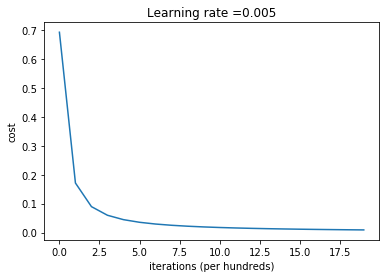

In [11]:
# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

learning rate is: 0.1
train accuracy: 100.0 %

-------------------------------------------------------

learning rate is: 0.01
train accuracy: 100.0 %

-------------------------------------------------------

learning rate is: 0.001
train accuracy: 100.0 %

-------------------------------------------------------

learning rate is: 0.0001
train accuracy: 100.0 %

-------------------------------------------------------



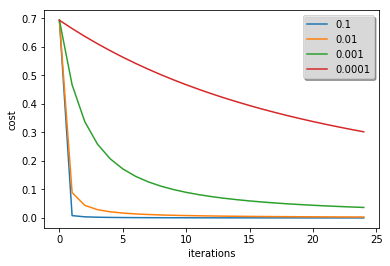

In [12]:
learning_rates = [0.1, 0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2500, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations')

legend = plt.legend(loc='upper right', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

In [13]:
import numpy as np
from scipy import linalg as la
from matplotlib import pyplot as plt
from scipy.stats import binom
import scipy.misc as misc
from sklearn.preprocessing import scale

In [14]:
def grad_lb(X, y, beta, m):
    '''
    This function calculates the gradient of the negative log-likelihood for the
    given values.
    
    X: An m x n array of features
    beta: An n vector of the current "solution" to the system
    y: An m vector of the number of successes, where y_i is the integer number of success for 
        a given trial. (Note that for our wdbc data, this is only 1 or 0)
    m: An m a vector of the number of trials (where m_i is the number of trials for the ith case)
        (Note that for our wdbc data, this is simply a vector of ones)
    '''
    
    Xbeta = np.dot(X, beta)
    # Takes the logistic function of Xbeta (inverse logit transform)
    w = sigmoid(Xbeta)
    # Calculate m_i * w_i - y_i using broadcasting
    mw_yX = (m * w - y).reshape(y.shape[0],1) * X
    # sum (m_iw_i - y_i)X over the rows
    gradlb = mw_yX.sum(axis=0)
    return gradlb


In [15]:
def grad2_lb(X, y, beta, m):
    '''
    This function calculates the gradient^2 of the negative log-likelihood for the
    given values.

    
    X: An m x n array of features
    beta: An n vector of the current "solution" to the system
    y: An m vector of the number of successes, where y_i is the integer number of success for 
        a given trial. (Note that for our wdbc data, this is only 1 or 0)
    m: A vector of the number of trials (where m_i is the number of trials for the ith case)
        (Note that for our wdbc data, this is simply a vector of ones)
    '''
    N, P = X.shape
    Xbeta = np.dot(X,beta)
    # Takes the logistic function of Xbeta (inverse logit transform)
    w = sigmoid(Xbeta)
    # Calculate m_iw_i(1-w_i) as the vector of scalar matrix "coefficients" for our sum
    # Here we use simple broadcasting
    coeff = m * w * (1. - w)
    grad2 = np.zeros((P,P))
    for i in np.arange(N):
        grad2 += coeff[i] * np.outer(X[i], X[i])
    return grad2


In [16]:
def negloglike(X, y, beta, m):
    '''
    This function computes the negative log likelihood given features X, successes y,
    trials m and solution vector beta.
    '''
    Xbeta = np.dot(X, beta)
    w = sigmoid(Xbeta)
    # Use scipy's binomial object to compute the log of the pmf, then take the sum   
    return -binom.logpmf(y, m, w).sum()


In [17]:
def NM_inverse(X, y, beta, m, iters=1000, tol=1e-3):
    '''
    This function implements newton's method on the negative log likelihood using
    simple inversion of the Hessian matrix (likely to be unstable)
    
    X: An m x n array of features
    beta: An n vector of the current "solution" to the system
    y: An m vector of the number of successes, where y_i is the integer number of success for 
        a given trial. (Note that for our wdbc data, this is only 1 or 0)
    m: An m a vector of the number of trials (where m_i is the number of trials for the ith case)
        (Note that for our wdbc data, this is simply a vector of ones)
    iters: An optional int indicating the maximum number of iterations to implement Newton's method
    
    '''
    ll = []
    betas = []
    beta0 = beta
    for i in np.arange(iters):
        ll.append(negloglike(X,y,beta0,m))
        betas.append(beta0)
        
        beta1 = beta0 - np.dot(la.inv(grad2_lb(X, y, beta0, m)), grad_lb(X,y,beta0,m))
        llb0 = negloglike(X,y,beta0,m)
        llb1 = negloglike(X,y,beta1,m)
        
        # Here we measure convergence based on the absolute difference of l(beta0) and l(beta1)
        if np.abs(llb0 - llb1) > tol:
            beta0 = beta1
        else:
            ll.append(negloglike(X,y,beta0,m))
            betas.append(beta1)
            return beta1, ll, betas, i
    
    return beta1, ll, betas, i


number of iterations to convergence for Newton method: 21
train accuracy: 100.0 %


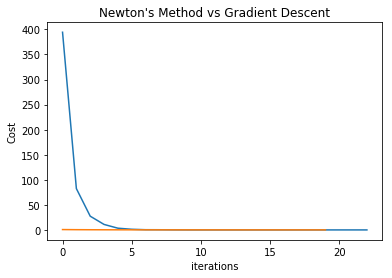

In [18]:
# Load in columns 3-12 of the wdbc data
X = np.loadtxt('../../../data/wdbc.csv', dtype='float', delimiter=',', usecols=np.arange(3,13))
X1 = scale(X, axis=1) # Scale X
X = np.hstack((np.ones((X.shape[0],1)), X1))
cl = np.loadtxt('../../../data/wdbc.csv', dtype='str', delimiter=',', usecols=[1])

# Set Malignant to be 1 and Benign to be 0
y = (cl == 'M').astype(float)
M = np.ones(y.shape[0])
m,n = X.shape


# Plot the convergence of the log likelihood 
for i in [np.zeros(n)]:

    beta0, ll, betas, i = NM_inverse(X,y,i,M, tol=1e-5)
    plt.plot(ll)

plt.title("Newton's Method vs Gradient Descent")
plt.xlabel("iterations")
plt.ylabel("Cost")
# plt.show()
print('number of iterations to convergence for Newton method:', i)



file_name = '../../../data/wdbc.csv'

(train_set_x, train_set_y, test_set_x, test_set_y) = load_data(file_name)
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.001, print_cost = False)

# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.plot(costs)
# plt.ylabel('cost')
# plt.xlabel('iterations (per hundreds)')
# plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()